In [67]:
#!mkdir celeba_gan
#!gdown --id 1O7m1010EJjLE5QxLZiM9Fpjs7Oj6e684 -O celeba_gan/data.zip
#!unzip -qq celeba_gan/data.zip -d celeba_gan

In [68]:
import keras

dataset = keras.utils.image_dataset_from_directory(
    'celeba_gan',
    label_mode=None,
    image_size=(64, 64),
    batch_size=32,
    smart_resize=True
)

dataset = dataset.map(lambda x: x / 255)

Found 202599 files belonging to 1 classes.


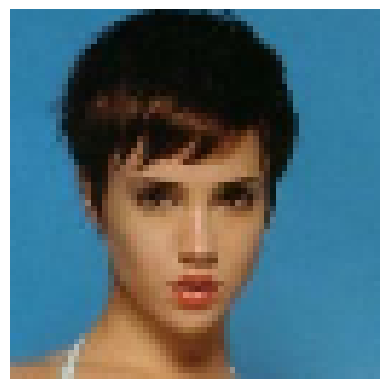

In [69]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
for x in dataset:
    plt.axis('off')
    plt.imshow((x.numpy()[0] * 255).astype(np.int32))
    break

In [70]:
from keras import layers, activations

discriminator = keras.Sequential([
    layers.Input(shape=(64, 64, 3)),
    layers.Conv2D(filters=64, kernel_size=4, strides=2, padding='same'),
    layers.LeakyReLU(alpha=0.2),
    layers.Conv2D(filters=128, kernel_size=4, strides=2, padding='same'),
    layers.LeakyReLU(alpha=0.2),
    layers.Conv2D(filters=128, kernel_size=4, strides=2, padding='same'),
    layers.LeakyReLU(alpha=0.2),
    layers.Flatten(),
    layers.Dropout(0.2),
    layers.Dense(1, activation=activations.sigmoid)],
    name='discriminator')

discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_32 (Conv2D)          (None, 32, 32, 64)        3136      
                                                                 
 leaky_re_lu_48 (LeakyReLU)  (None, 32, 32, 64)        0         
                                                                 
 conv2d_33 (Conv2D)          (None, 16, 16, 128)       131200    
                                                                 
 leaky_re_lu_49 (LeakyReLU)  (None, 16, 16, 128)       0         
                                                                 
 conv2d_34 (Conv2D)          (None, 8, 8, 128)         262272    
                                                                 
 leaky_re_lu_50 (LeakyReLU)  (None, 8, 8, 128)         0         
                                                                 
 flatten_8 (Flatten)         (None, 8192)            

In [71]:
latent_dim = 128

generator = keras.Sequential([
    keras.Input(shape=(latent_dim,)),
    layers.Dense(8 * 8 * 128),
    layers.Reshape((8, 8, 128)),
    layers.Conv2DTranspose(filters=128, kernel_size=4, strides=2, padding='same'),
    layers.LeakyReLU(alpha=0.2),
    layers.Conv2DTranspose(filters=256, kernel_size=4, strides=2, padding='same'),
    layers.LeakyReLU(alpha=0.2),
    layers.Conv2DTranspose(filters=512, kernel_size=4, strides=2, padding='same'),
    layers.LeakyReLU(alpha=0.2),
    layers.Conv2D(filters=3, kernel_size=5, padding='same', activation=activations.sigmoid)],
    name='generator')

generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_17 (Dense)            (None, 8192)              1056768   
                                                                 
 reshape_8 (Reshape)         (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose_24 (Conv2  (None, 16, 16, 128)       262272    
 DTranspose)                                                     
                                                                 
 leaky_re_lu_51 (LeakyReLU)  (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose_25 (Conv2  (None, 32, 32, 256)       524544    
 DTranspose)                                                     
                                                                 
 leaky_re_lu_52 (LeakyReLU)  (None, 32, 32, 256)       0 

In [72]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_loss_metric = keras.metrics.Mean(name='d_loss')
        self.g_loss_metric = keras.metrics.Mean(name='g_loss')
    
    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
    
    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]
    
    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        generated_images = self.generator(random_latent_vectors)
        combined_images = tf.concat([generated_images, real_images], axis=0)
        labels = tf.concat([
            tf.ones((batch_size, 1)),
            tf.zeros((batch_size, 1))],
            axis=0)
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        
        d_grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(zip(d_grads, self.discriminator.trainable_weights))

        # grads = tape.gradient(d_loss, [self.discriminator.trainable_weights, self.generator.trainable_weights])
        # d_grads = grads[0]
        # g_grads = grads[1]
        # self.d_optimizer.apply_gradients(zip(d_grads, self.discriminator.trainable_weights))
        # self.g_optimizer.apply_gradients(zip(tf.negative(g_grads), self.generator.trainable_weights))

        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        misleading_labels = tf.zeros((batch_size, 1))
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        g_grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(g_grads, self.generator.trainable_weights))

        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {'d_loss': self.d_loss_metric.result(),
                'g_loss': self.g_loss_metric.result()}

In [73]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim
    
    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = keras.utils.array_to_img(generated_images[i])
            img.save(f'generated_img_{epoch:03d}_{i}.png')

In [74]:
epochs = 100

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    g_optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss_fn=keras.losses.BinaryCrossentropy())

gan.fit(dataset, epochs=epochs, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)])

Epoch 1/100


2023-10-06 10:57:17.346156: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8600
2023-10-06 10:57:18.528953: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f69400f5d60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-06 10:57:18.528972: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2023-10-06 10:57:18.531714: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-06 10:57:18.591683: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


6332/6332 [==============================] - 208s 32ms/step - d_loss: 0.6088 - g_loss: 1.1713
Epoch 2/100
6332/6332 [==============================] - 187s 30ms/step - d_loss: 0.6543 - g_loss: 1.0493
Epoch 3/100
6332/6332 [==============================] - 183s 29ms/step - d_loss: 0.6658 - g_loss: 0.9949
Epoch 4/100
6332/6332 [==============================] - 180s 28ms/step - d_loss: 0.6596 - g_loss: 1.0042
Epoch 5/100
6332/6332 [==============================] - 168s 26ms/step - d_loss: 0.6468 - g_loss: 1.0516
Epoch 6/100
6332/6332 [==============================] - 176s 28ms/step - d_loss: 0.6614 - g_loss: 0.9958
Epoch 7/100
6332/6332 [==============================] - 182s 29ms/step - d_loss: 0.6672 - g_loss: 0.9400
Epoch 8/100
6332/6332 [==============================] - 162s 26ms/step - d_loss: 0.6740 - g_loss: 0.9302
Epoch 9/100
6332/6332 [==============================] - 161s 25ms/step - d_loss: 0.6725 - g_loss: 0.9033
Epoch 10/100
6332/6332 [==============================] - 

KeyboardInterrupt: 